Training parameters (from 'source/parameters.py'):

In [ ]:
training = {
    'window_width' : 20, #[5,10,20,50,200]
    'kernel_num' : 20, #[20,40,80,200], #40
    'epochs' :  60, 
    'batch_size':  1, #[16, 32, 64, 256], #32
    'learning_rate' : 0.001, #ups 0.001
    'target_from_theo_pept' : 0.005,
    'topN': 5000,
    # 'open_window_search' : False,
    'print_info' : True,
    # 'aux_peak_type' : True,
    'clip_value': 1,
    'layer_num': 2, #[2,3,5,10,20] #2
    'cand_from_search_qval' : 0.005, 
    'topN_exp' : 0,
    'print_info': True,
    'printing_tick': 1 # print learning update after this many epochs
}

Slider version:

In [ ]:
class DeepConv(torch.nn.Module):
    """
    Make a convolution layer with untrainable center explicitly.
    """
    def __init__(self,window_width, kernel_num, activation_fnc=torch.nn.functional.relu, spectrum_size=None, torch_device=None, torch_type=None):
        super(DeepConv,self).__init__()
        self.__class__.__name__ += '_'+activation_fnc.__class__.__name__
        self.window_width = window_width
        self.kernel_num = kernel_num
        bias = True
        self.sigmoid = torch.nn.Sigmoid()
    
        in_channels = 1
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=1), # num_features = channels
            torch.nn.Conv2d(in_channels, self.kernel_num, kernel_size=(3, self.window_width*2+1), padding=(1, self.window_width), bias=bias),
            torch.nn.BatchNorm2d(num_features=self.kernel_num),
            torch.nn.Sigmoid(),
            )
            
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(self.kernel_num, 1, 1, padding=0, bias=bias),
            torch.nn.BatchNorm2d(num_features=1),
            )
        self.bias =  torch.nn.Parameter(torch.tensor(5.0, requires_grad=True))# nn.Parameters(torch.zeros(1))
        self.offset = torch.tensor(0.0/self.kernel_num)

    def forward(self, x):
        out = self.layer1(x) - self.offset   # shape: [batch_size, channel, spectrum_bin]
        out = self.layer2(out)
        #pooling = torch.nn.MaxPool2d((out.shape[2], 1), stride=1)
        #out = pooling(out) - self.offset - self.bias
        out = out - self.offset - self.bias
        return self.sigmoid(out)
    
    def clip_grads(self, clip_value=0.0001):
        # for layer in self.layers:
        self.layer1[0].weight.grad.data.clamp_(min=-clip_value, max=clip_value)
        self.layer2[0].weight.grad.data.clamp_(min=-clip_value, max=clip_value)
       
            
class BCELossWeight(torch.nn.BCELoss):
    """
    Make a convolution layer with untrainable center explicitly.
    """
    def __init__(self,pos_weight):
        super(torch.nn.BCELoss,self).__init__()
        # self.__class__.__name__ += '_'+"_pos_weight"
        self.pos_weight = pos_weight
        self.tiny = 1e-20
      
    def forward(self, estimated, target):
        cost = self.pos_weight*target*torch.log(estimated + self.tiny) + (1-target)*torch.log(1-estimated + self.tiny)

        return -cost.mean()

Learning curve:

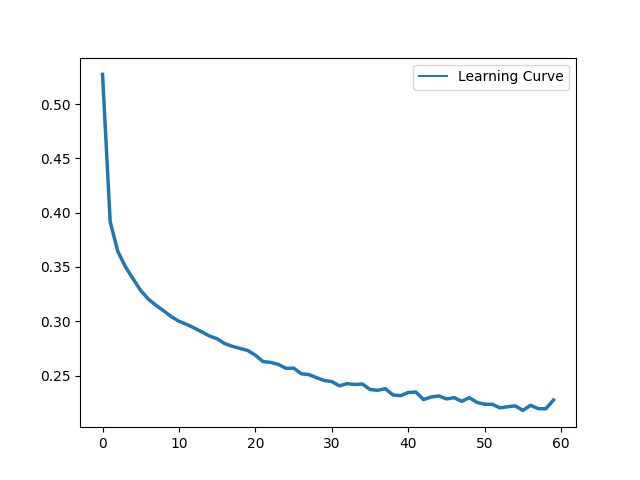

In [1]:
from PIL import Image
learning_curve = Image.open(r"c:\\Users\poder\lab\Slider_DIA\results\60_ep_20_ww_20_kn_0.001_lr.png")
display(learning_curve)